<a href="https://colab.research.google.com/github/EleaReggiani/AdRecognition/blob/main/v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CNN DOGS BREED RECOGNITION**

 **IMPORT THE LIBRAIRIES**

In [1]:
# files loading
import os

from random import shuffle
import numpy as np

from tqdm import tqdm # progress bar

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [4]:
# libraries for a CNN
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import timeit


In [5]:
from tensorflow import keras
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [6]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa


In [7]:
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

 **GPU FOR BETTER SPEED DURING CNN COMPILING AND RUNNING**

In [8]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#**LITTLE EDA**

In [9]:
ANNOTATION_DIR = '/content/drive/MyDrive/Deeplearniing/Annotation' 
IMAGES_DIR = '/content/drive/MyDrive/Deeplearniing/Images'

In [10]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [11]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:60]

['miniature_poodle',
 'dingo',
 'toy_poodle',
 'standard_poodle',
 'Cardigan',
 'Brabancon_griffon',
 'Pembroke',
 'dhole',
 'Mexican_hairless',
 'African_hunting_dog',
 'chow',
 'Samoyed',
 'basenji',
 'pug',
 'Great_Pyrenees',
 'Leonberg',
 'keeshond',
 'Newfoundland',
 'Pomeranian',
 'affenpinscher',
 'Great_Dane',
 'malamute',
 'bull_mastiff',
 'French_bulldog',
 'boxer',
 'EntleBucher',
 'Saint_Bernard',
 'Eskimo_dog',
 'Siberian_husky',
 'Tibetan_mastiff',
 'collie',
 'Border_collie',
 'Bouvier_des_Flandres',
 'Greater_Swiss_Mountain_dog',
 'Doberman',
 'miniature_pinscher',
 'Bernese_mountain_dog',
 'Appenzeller',
 'German_shepherd',
 'Rottweiler',
 'kuvasz',
 'Irish_water_spaniel',
 'Shetland_sheepdog',
 'kelpie',
 'komondor',
 'briard',
 'Old_English_sheepdog',
 'malinois',
 'groenendael',
 'schipperke',
 'Welsh_springer_spaniel',
 'Brittany_spaniel',
 'cocker_spaniel',
 'English_springer',
 'Irish_setter',
 'vizsla',
 'English_setter',
 'Gordon_setter',
 'clumber',
 'Sussex_s

n02112137-chow


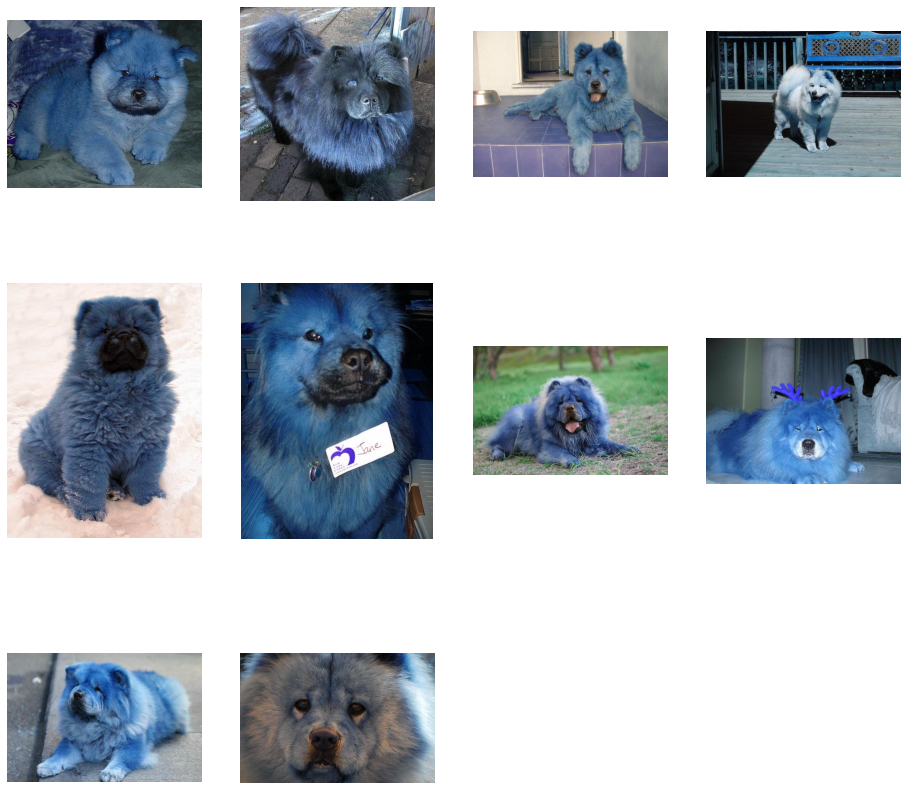

In [12]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/content/drive/MyDrive/Deeplearniing/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[10])
show_dir_images(breed_list[10], 10)

# **PREPROCESSING**

**IMAGES EQUALIZATION FOR BETTER ACCURACY**

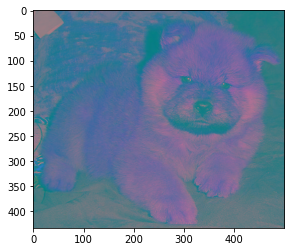

In [13]:
img_dir = "/content/drive/MyDrive/Deeplearniing/Images/{}/".format(breed_list[10])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

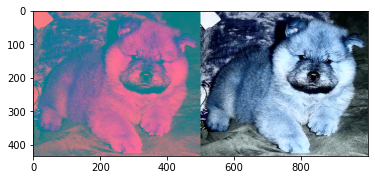

In [14]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

**DATA AUGMENATION :**

Augmented by rotation:


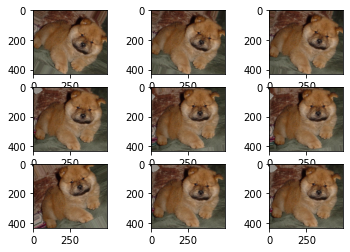

<Figure size 720x720 with 0 Axes>

In [15]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

**PROCESSING ON 30 BREEDS**

In [16]:
num_breeds = 30 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 224 x 224 because the input image resolution for VGG16 is 224 x 224
            resized_img = img_array.resize((224, 224))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  5218 
No. of labels loaded =  5218
<class 'list'> <class 'list'>


In [17]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (5218, 224, 224, 3) 
Labels shape =  (5218,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [2646  691 1773 2589 4157 1084 3276  426 1115 4852]


In [19]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (5218, 224, 224, 3) 
Labels shape after shuffling =  (5218,)
same shapes before and after shuffling


In [20]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

**TRAIN, TEST, VALIDATION DATA**

In [21]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (3756, 224, 224, 3)
y_train shape =  (3756,)

x_val shape =  (418, 224, 224, 3)
y_val shape =  (418,)

x_test shape =  (1044, 224, 224, 3)
y_test shape =  (1044,)


**DATA AUGMENATION FOR X_TRAIN**

In [22]:
datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train, augment=True)

**CONSTRUCTING CNN FROM SCRATCH**

In [23]:
model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(120, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        9

In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0015)

In [25]:
%%time
history =model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=33)

Epoch 1/33
118/118 [==============================] - 38s 67ms/step - loss: 3.7527 - accuracy: 0.0687 - val_loss: 4.2967 - val_accuracy: 0.0407
Epoch 2/33
118/118 [==============================] - 6s 47ms/step - loss: 3.0030 - accuracy: 0.1522 - val_loss: 4.0673 - val_accuracy: 0.0670
Epoch 3/33
118/118 [==============================] - 6s 48ms/step - loss: 2.8298 - accuracy: 0.1952 - val_loss: 3.3903 - val_accuracy: 0.0981
Epoch 4/33
118/118 [==============================] - 6s 48ms/step - loss: 2.7052 - accuracy: 0.2268 - val_loss: 3.5222 - val_accuracy: 0.1053
Epoch 5/33
118/118 [==============================] - 6s 48ms/step - loss: 2.5243 - accuracy: 0.2564 - val_loss: 2.8419 - val_accuracy: 0.2105
Epoch 6/33
118/118 [==============================] - 6s 48ms/step - loss: 2.4641 - accuracy: 0.2732 - val_loss: 3.0144 - val_accuracy: 0.2129
Epoch 7/33
118/118 [==============================] - 6s 48ms/step - loss: 2.3678 - accuracy: 0.3073 - val_loss: 2.6895 - val_accuracy: 0.224

**ACCURACY**

In [26]:
loss, accuracy = model.evaluate(x_test, y_test)

print(loss,accuracy)

33/33 [==============================] - 1s 24ms/step - loss: 3.8263 - accuracy: 0.2193
3.8262953758239746 0.21934865415096283


**LEARNING CURVES**

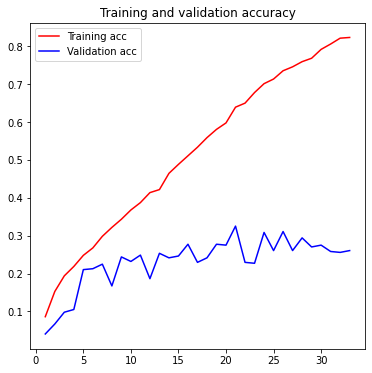

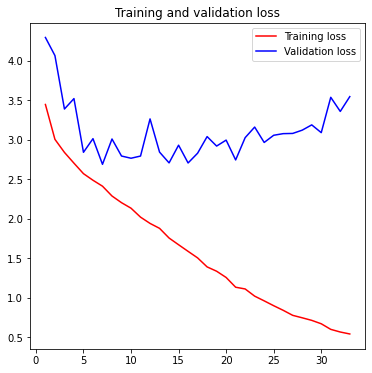

In [27]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**PREDICTION WITH TEST**

In [28]:
pred = model.predict(x_test)

pred.shape

(1044, 120)

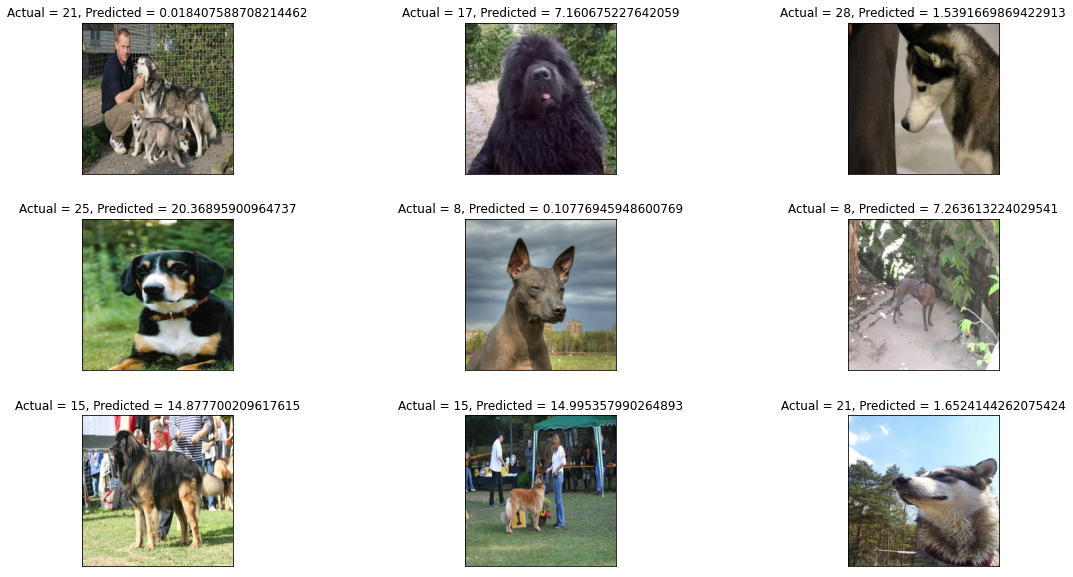

In [29]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

**TRASNFER LEARNING WITH VGG16**

In [37]:

from keras.applications.vgg16 import VGG16
modelVGG16 = VGG16(input_tensor=Input(shape=(224, 224, 3)))
custom_transfert_learning = Sequential()
for layer in modelVGG16.layers[:-1]:
  custom_transfert_learning.add(layer)
  custom_transfert_learning.summary()

for layer in custom_transfert_learning.layers:
  layer.trainable = False

custom_transfert_learning.add(Dense(units=30, activation='softmax'))

custom_transfert_learning.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
Total params: 

In [38]:
modelVGG16.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(modelVGG16.optimizer.learning_rate, 0.0015)

In [39]:
historyVGG16 =modelVGG16.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=17)

Epoch 1/17
118/118 [==============================] - 35s 288ms/step - loss: 4.1825 - accuracy: 0.0767 - val_loss: 3.0959 - val_accuracy: 0.1938
Epoch 2/17
118/118 [==============================] - 34s 286ms/step - loss: 2.8620 - accuracy: 0.2104 - val_loss: 3.2561 - val_accuracy: 0.1531
Epoch 3/17
118/118 [==============================] - 34s 285ms/step - loss: 2.5588 - accuracy: 0.2946 - val_loss: 2.5409 - val_accuracy: 0.2297
Epoch 4/17
118/118 [==============================] - 34s 285ms/step - loss: 2.2876 - accuracy: 0.3389 - val_loss: 2.4354 - val_accuracy: 0.2943
Epoch 5/17
118/118 [==============================] - 33s 284ms/step - loss: 2.2046 - accuracy: 0.3673 - val_loss: 2.3812 - val_accuracy: 0.3206
Epoch 6/17
118/118 [==============================] - 34s 285ms/step - loss: 2.1662 - accuracy: 0.3817 - val_loss: 2.6039 - val_accuracy: 0.2679
Epoch 7/17
118/118 [==============================] - 34s 285ms/step - loss: 2.1313 - accuracy: 0.3818 - val_loss: 2.2700 - val_ac

**ACCURACY :**

In [40]:
loss, accuracy = modelVGG16.evaluate(x_test, y_test)

print(loss,accuracy)

33/33 [==============================] - 8s 255ms/step - loss: 2.3718 - accuracy: 0.3745
2.3717639446258545 0.37452107667922974


**LEARNING CURVES**

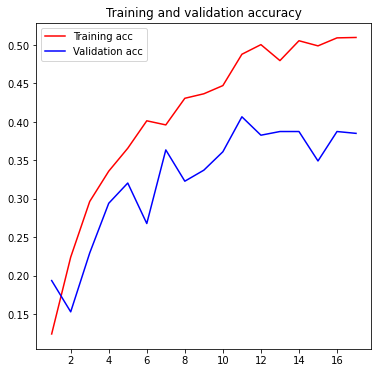

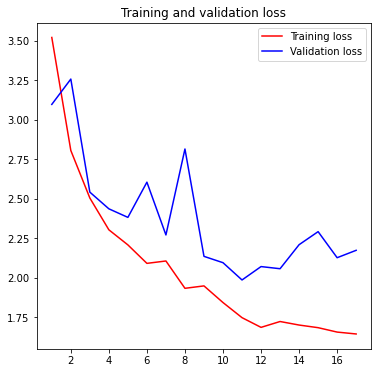

In [41]:
plt.rcParams['figure.figsize'] = (6,6)

acc = historyVGG16.history['accuracy']
val_acc = historyVGG16.history['val_accuracy']
loss = historyVGG16.history['loss']
val_loss = historyVGG16.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**PREDICTION**

In [42]:
pred = modelVGG16.predict(x_test)

pred.shape

(1044, 1000)

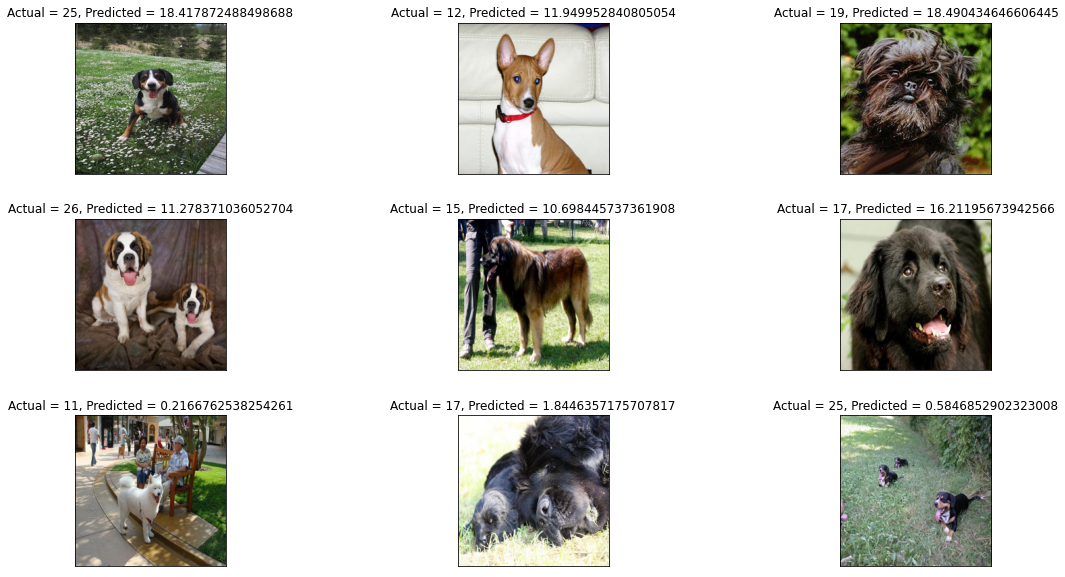

In [43]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()